In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
x = np.array(([3,5], [5,1], [7,3], [8,0], [2,8], [4,2], [10,2]), dtype=float)
g_y = np.array(([75], [82], [95], [82], [54], [72], [93]), dtype=float)
x = x/np.amax(x, axis=0)
g_y = g_y/100

In [3]:
class neural_net(object):
    def __init__(self):
        # the hyperparams
        self.input_size = 2
        self.output_size = 1
        self.hidden_size = 3
        
        # initial weights
        self.w1 = np.random.randn(self.input_size, self.hidden_size)
        self.w2 = np.random.randn(self.hidden_size, self.output_size)
        
    def forward(self, input_x):
        self.z2 = np.dot(input_x, self.w1)
        self.a2 = self.tanh(self.z2)
        self.z3 = np.dot(self.a2, self.w2)
        output_y = self.tanh(self.z3)
        return output_y
        
    def sigmoid(self, input_z):
        return 1/(1+np.exp(-input_z))
    
    def sigmoid_prime(self, input_z):
        return np.exp(-input_z)/((1+np.exp(-input_z))**2)
    
    def tanh(self, input_z):
        return np.tanh(input_z)
    
    def tanh_prime(self, input_z):
        return np.ones(input_z.shape)-np.square(np.tanh(input_z))
    
    def relu(self, input_z):
        return np.where(input_z > np.zeros(input_z.shape), input_z, np.zeros(input_z.shape))
    
    def relu_prime(self, input_z):
        return np.where(input_z > np.zeros(input_z.shape), np.ones(input_z.shape), np.zeros(input_z.shape))
    
    def ecos_relu(self, input_z):
        return np.where(input_z > np.zeros(input_z.shape), 
                        np.cos(input_z)+input_z-np.ones(input_z.shape), 
                        np.expm1(input_z))
    
    def ecos_relu_prime(self, input_z):
        return np.where(input_z > np.zeros(input_z.shape), 
                        -np.sin(input_z)+np.ones(input_z.shape), 
                        np.exp(input_z))
    
    def cost_function(self, input_x, ground_truth_y):
        #Compute cost for given X,y, use weights already stored in class.
        self.output_y = self.forward(input_x)
        J = 0.5*np.sum((ground_truth_y-self.output_y)**2)
        return J
    
    def cost_function_prime(self, input_x, ground_truth_y):
        self.output_y = self.forward(input_x)
        
        delta_3 = np.multiply(-(ground_truth_y-self.output_y), self.tanh_prime(self.z3))
        dj_dw2 = np.dot(self.a2.T, delta_3)
        
        delta_2 = np.dot(delta_3, self.w2.T)*self.tanh_prime(self.z2)
        dj_dw1 = np.dot(input_x.T, delta_2)
        
        return dj_dw1, dj_dw2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.w1.ravel(), self.w2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        w1_start = 0
        w1_end = self.hidden_size * self.input_size
        self.w1 = np.reshape(params[w1_start:w1_end], (self.input_size , self.hidden_size))
        w2_end = w1_end + self.hidden_size*self.output_size
        self.w2 = np.reshape(params[w1_end:w2_end], (self.hidden_size, self.output_size))
        
    def computeGradients(self, input_x, output_y):
        dj_dw1, dj_dw2 = self.cost_function_prime(input_x, output_y)
        return np.concatenate((dj_dw1.ravel(), dj_dw2.ravel()))

In [4]:
def numerical_gradient(N, input_x, output_y):
    paramsInitial = N.getParams()
    numgrad = np.zeros(paramsInitial.shape)
    perturb = np.zeros(paramsInitial.shape)
    e = 1e-4

    for p in range(len(paramsInitial)):
        #Set perturbation vector
        perturb[p] = e
        N.setParams(paramsInitial + perturb)
        loss2 = N.cost_function(input_x, output_y)

        N.setParams(paramsInitial - perturb)
        loss1 = N.cost_function(input_x, output_y)

        #Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e)

        #Return the value we changed to zero:
        perturb[p] = 0

    #Return Params to original value:
    N.setParams(paramsInitial)

    return numgrad

In [5]:
nn = neural_net()

In [6]:
numgrad = numerical_gradient(nn, x, g_y)
grad = nn.computeGradients(x, g_y)

In [7]:
numgrad

array([ 0.26319159,  0.75938358,  0.10807427,  0.57221684,  0.56789385,
        0.20918087,  1.35570919, -1.46720755,  1.60097225])

In [8]:
grad

array([ 0.26319159,  0.75938358,  0.10807427,  0.57221684,  0.56789385,
        0.20918087,  1.35570919, -1.46720755,  1.60097225])

In [9]:
np.sum(grad-numgrad)/np.sum(grad+numgrad)

-1.8400457811247232e-09

In [10]:
class trainer(object):
    def __init__(self, N):
        self.n = N
        
    def callback_function(self, params):
        self.n.setParams(params)
        self.j.append(self.n.cost_function(self.input_x, self.ground_truth_y))
        
    def cost_function_wrapper(self, params, input_x, ground_truth_y):
        self.n.setParams(params)
        cost = self.n.cost_function(input_x, ground_truth_y)
        grad = self.n.computeGradients(input_x, ground_truth_y)
        
        return cost, grad
        
    def train(self, input_x, ground_truth_y):
        #Make an internal variable for the callback function:
        self.input_x = input_x
        self.ground_truth_y = ground_truth_y

        #Make empty list to store costs:
        self.j = []
        
        params0 = self.n.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.cost_function_wrapper, params0, jac=True, method='BFGS', \
                                 args=(input_x, ground_truth_y), options=options, callback=self.callback_function)

        self.n.setParams(_res.x)
        self.optimizationResults = _res

In [11]:
T = trainer(nn)
T.train(x, g_y)

         Current function value: 0.000280
         Iterations: 200
         Function evaluations: 227
         Gradient evaluations: 227


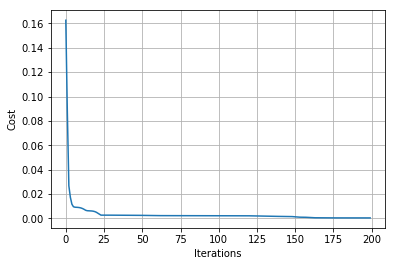

In [12]:
plt.plot(T.j)
plt.grid(1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [13]:
#Test network for various combinations of sleep/study:
hoursSleep = np.linspace(0, 10, 100)
hoursStudy = np.linspace(0, 5, 100)

#Normalize data (same way training data way normalized)
hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

#Create 2-d versions of input for plotting
a, b  = np.meshgrid(hoursSleepNorm, hoursStudyNorm)

#Join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

In [14]:
allOutputs = nn.forward(allInputs)

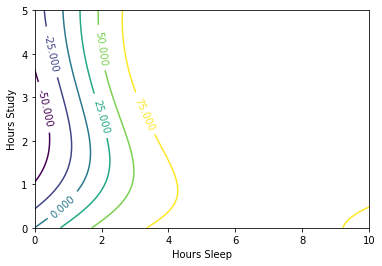

In [15]:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = plt.contour(xx,yy,100*allOutputs.reshape(100, 100))
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('Hours Sleep')
plt.ylabel('Hours Study')
plt.show()

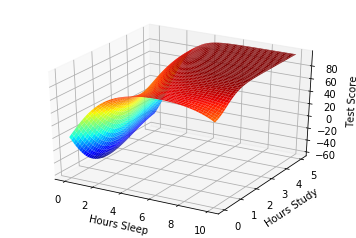

In [16]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=plt.cm.jet)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')
plt.show()

In [17]:
print(nn.forward(x))
print(g_y)

[[ 0.7462061 ]
 [ 0.80986526]
 [ 0.96975649]
 [ 0.82290171]
 [ 0.54077071]
 [ 0.72498535]
 [ 0.9256813 ]]
[[ 0.75]
 [ 0.82]
 [ 0.95]
 [ 0.82]
 [ 0.54]
 [ 0.72]
 [ 0.93]]
